In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{0}"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torchvision import transforms
import joblib
from torchsummary import summary
import pytorch_ssim
import wandb

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initial settings

In [3]:
lr=0.001

t0 = time.time()

print(t0)

root_path = '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/'

1711397510.0806594


## Load building data

In [4]:
concatenated_data = np.load("/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/InterpolatedResult256/FpB_Interpolated_t0_VelocityAbsorption_256_256.npy")
print(concatenated_data.shape)

(2, 256, 256)


In [5]:
concatenated_data_revalued = concatenated_data.copy()
concatenated_data_revalued[concatenated_data > 1500] = 1
concatenated_data_revalued[concatenated_data <= 1500] = 0

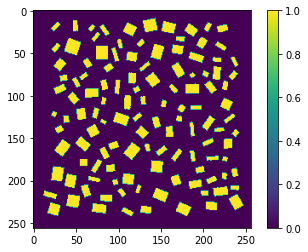

In [6]:
plt.imshow(concatenated_data_revalued[0,:,:])
plt.colorbar()

In [7]:
concatenated_data_revalued = concatenated_data_revalued[0,:,:].reshape(1,256,256)
print(concatenated_data_revalued.shape)

(1, 256, 256)


In [8]:
# Original image
original_image = concatenated_data_revalued

# Rotate the image 90 degrees three times to create three new images
rotated_image1 = np.rot90(original_image, 1, axes=(1, 2))  # 90 degrees rotation
rotated_image2 = np.rot90(original_image, 2, axes=(1, 2))  # 180 degrees rotation
rotated_image3 = np.rot90(original_image, 3, axes=(1, 2))  # 270 degrees rotation

# Stack the original image and the rotated images along the 0th dimension
all_images = np.stack((original_image, rotated_image1, rotated_image2, rotated_image3), axis=0)

print(all_images.shape)  # Should print (4, 1, 256, 256)

(4, 1, 256, 256)


In [9]:
# Original image
original_image_384 = concatenated_data_revalued_384

# Rotate the image 90 degrees three times to create three new images
rotated_image1_384 = np.rot90(original_image_384, 1, axes=(1, 2))  # 90 degrees rotation
rotated_image2_384 = np.rot90(original_image_384, 2, axes=(1, 2))  # 180 degrees rotation
rotated_image3_384 = np.rot90(original_image_384, 3, axes=(1, 2))  # 270 degrees rotation

# Stack the original image and the rotated images along the 0th dimension
all_images_384 = np.stack((original_image_384, rotated_image1_384, rotated_image2_384, rotated_image3_384), axis=0)

print(all_images_384.shape)  # Should print (4, 1, 384, 384)

NameError: name 'concatenated_data_revalued_384' is not defined

## Create data loader

In [10]:
batch_size = 4

# dataloader = DataLoader(concatenated_data_revalued)
dataloader1 = DataLoader(all_images, batch_size=batch_size)

dataloader2 = DataLoader(all_images_384, batch_size=batch_size)

NameError: name 'all_images_384' is not defined

## Define the model

### latent_channel_number = 1

In [9]:
fist_hidden_layer = 16
second_hidden_layer = 32
latent_channel_number = 1


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer, latent_channel_number, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.1)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channel_number, fist_hidden_layer, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(fist_hidden_layer, 1, kernel_size=2, stride=2, padding=0),   
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (1,256, 256))
summary(autoencoder, (1,384, 384))
summary(autoencoder, (1,384*2, 384*2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]              80
         LeakyReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           2,080
         LeakyReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 16, 65, 65]           2,064
         LeakyReLU-6           [-1, 16, 65, 65]               0
            Conv2d-7            [-1, 1, 64, 64]              65
         LeakyReLU-8            [-1, 1, 64, 64]               0
   ConvTranspose2d-9           [-1, 16, 65, 65]              80
        LeakyReLU-10           [-1, 16, 65, 65]               0
  ConvTranspose2d-11           [-1, 32, 64, 64]           2,080
        LeakyReLU-12           [-1, 32, 64, 64]               0
  ConvTranspose2d-13         [-1, 16, 128, 128]           2,064
        LeakyReLU-14         [-1, 16, 1

### latent_channel_number = 2

In [18]:
fist_hidden_layer = 16
second_hidden_layer = 32
latent_channel_number = 2


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer, latent_channel_number, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.1)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channel_number, fist_hidden_layer, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(fist_hidden_layer, 1, kernel_size=2, stride=2, padding=0),   
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [19]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (1,256, 256))
summary(autoencoder, (1,384, 384))
summary(autoencoder, (1,384*2, 384*2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]              80
         LeakyReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           2,080
         LeakyReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 16, 65, 65]           2,064
         LeakyReLU-6           [-1, 16, 65, 65]               0
            Conv2d-7            [-1, 2, 64, 64]             130
         LeakyReLU-8            [-1, 2, 64, 64]               0
   ConvTranspose2d-9           [-1, 16, 65, 65]             144
        LeakyReLU-10           [-1, 16, 65, 65]               0
  ConvTranspose2d-11           [-1, 32, 64, 64]           2,080
        LeakyReLU-12           [-1, 32, 64, 64]               0
  ConvTranspose2d-13         [-1, 16, 128, 128]           2,064
        LeakyReLU-14         [-1, 16, 1

### latent_channel_number = 2 latent size 32

In [11]:
# fist_hidden_layer = 16*4*2
# second_hidden_layer = 32*4*2
# latent_channel_number = 2


# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()

#         # Encoder layers
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.Conv2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=2, padding=0),  
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.Conv2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=1, padding=1),  
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.Conv2d(fist_hidden_layer, 64, kernel_size=2, stride=1, padding=0),  
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),#5 - Smoothing the change in number of channels; no reduction in output size
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.Conv2d(32, 2, kernel_size=2, stride=2, padding=0),  
#             nn.LeakyReLU(negative_slope=0.1),
#         )

#         # Decoder layers
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(2, 32, kernel_size=2, stride=2, padding=0),  
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1, padding=1),#5 - Smoothing the change in number of channels; no reduction in output size
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.ConvTranspose2d(64, fist_hidden_layer, kernel_size=2, stride=1, padding=0),  
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.ConvTranspose2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=1, padding=1),  
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.ConvTranspose2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.ConvTranspose2d(fist_hidden_layer, 1, kernel_size=2, stride=2, padding=0),   
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [12]:
fist_hidden_layer = 16*4*2
second_hidden_layer = 32*4*2
latent_channel_number = 2


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, fist_hidden_layer*2, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer*2, second_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer, 64, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            # nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),#5 - Smoothing the change in number of channels; no reduction in output size
            # nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(64, 1, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 64, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            # nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1, padding=1),#5 - Smoothing the change in number of channels; no reduction in output size
            # nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(64, fist_hidden_layer, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(fist_hidden_layer, 1, kernel_size=2, stride=2, padding=0),   
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (1,256, 256))
summary(autoencoder, (1,384, 384))
summary(autoencoder, (1,384*2, 384*2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 128, 128]           1,280
         LeakyReLU-2        [-1, 256, 128, 128]               0
            Conv2d-3          [-1, 256, 64, 64]         262,400
         LeakyReLU-4          [-1, 256, 64, 64]               0
            Conv2d-5          [-1, 128, 65, 65]         131,200
         LeakyReLU-6          [-1, 128, 65, 65]               0
            Conv2d-7           [-1, 64, 64, 64]          32,832
         LeakyReLU-8           [-1, 64, 64, 64]               0
            Conv2d-9            [-1, 1, 32, 32]             257
        LeakyReLU-10            [-1, 1, 32, 32]               0
  ConvTranspose2d-11           [-1, 64, 64, 64]             320
        LeakyReLU-12           [-1, 64, 64, 64]               0
  ConvTranspose2d-13          [-1, 128, 65, 65]          32,896
        LeakyReLU-14          [-1, 128,

### Containing kernel size 3

In [88]:
# Define the autoencoder model
hid1 = 20
hid2= 40
hid3 = 80
hid4 = 80
hid5 = 40
hid6 = 20

latent = 8
            
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
 
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hid1, kernel_size=3, stride=1, padding=1),#1 - Smoothing the change in number of channels; no reduction in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid1, hid2, kernel_size=2, stride=2),#2 - reduction by 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid2, hid3, kernel_size=3, stride=1, padding=1),#3 - Smoothing the change in number of channels; no reduction in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid3, hid4, kernel_size=2, stride=2),#4 - reduction by 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid4, hid5, kernel_size=3, stride=1, padding=1),#5 - Smoothing the change in number of channels; no reduction in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid5, hid6, kernel_size=2, stride=2),#6 - reduction by 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid6, latent, kernel_size=3, stride=1, padding=1),#7 - Smoothing the change in number of channels; no reduction in output size
            #We should finish with the same number of channels of the input (4)
            nn.LeakyReLU(negative_slope=0.2)
            # nn.Tanh()  
        )
 
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent, hid6, kernel_size=3, stride=1, padding=1),# Smoothing the change in number of channels; no increase in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid6, hid5, kernel_size=2, stride=2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid5, hid4, kernel_size=3, stride=1, padding=1),# Smoothing the change in number of channels; no increase in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid4, hid3, kernel_size=2, stride=2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid3, hid2, kernel_size=3, stride=1, padding=1),# Smoothing the change in number of channels; no increase in output size
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid2, hid1, kernel_size=2, stride=2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid1, 1, kernel_size=3, stride=1, padding=1),# Smoothing the change in number of channels; no increase in output size
            # nn.Identity()
            nn.Sigmoid()
        )
 
    def forward(self, x):
        x = self.encoder(x)
        # print(x.shape)
        x = self.decoder(x)
        # print(x.shape)
        return x

In [89]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (1, 256, 256))
summary(autoencoder, (1, 384, 384))
summary(autoencoder, (1, 384*2, 384*2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 20, 256, 256]             200
         LeakyReLU-2         [-1, 20, 256, 256]               0
            Conv2d-3         [-1, 40, 128, 128]           3,240
         LeakyReLU-4         [-1, 40, 128, 128]               0
            Conv2d-5         [-1, 80, 128, 128]          28,880
         LeakyReLU-6         [-1, 80, 128, 128]               0
            Conv2d-7           [-1, 80, 64, 64]          25,680
         LeakyReLU-8           [-1, 80, 64, 64]               0
            Conv2d-9           [-1, 40, 64, 64]          28,840
        LeakyReLU-10           [-1, 40, 64, 64]               0
           Conv2d-11           [-1, 20, 32, 32]           3,220
        LeakyReLU-12           [-1, 20, 32, 32]               0
           Conv2d-13            [-1, 8, 32, 32]           1,448
        LeakyReLU-14            [-1, 8,

In [116]:
# Define the autoencoder model
hid1 = 20*2
hid2= 40*2
hid3 = 80*2
latent = 1

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
 
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hid1, kernel_size=3, stride=2, padding=1),  # Changed stride to 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid1, hid2, kernel_size=3, stride=2, padding=1),  # Changed stride to 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid2, hid3, kernel_size=3, stride=2, padding=1),  # Changed stride to 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid3, latent, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2)
        )
 
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent, hid3, kernel_size=3, stride=2, padding=1, output_padding=1),  # Changed stride to 2 and added output_padding
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid3, hid2, kernel_size=3, stride=2, padding=1, output_padding=1),  # Changed stride to 2 and added output_padding
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid2, hid1, kernel_size=3, stride=2, padding=1, output_padding=1),  # Changed stride to 2 and added output_padding
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(hid1, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        print(x.shape)
        x = self.encoder(x)
        print(x.shape)
        x = self.decoder(x)
        print(x.shape)
        return x

In [117]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (1, 256, 256))
summary(autoencoder, (1, 384, 384))
summary(autoencoder, (1, 384*2, 384*2))

torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 32, 32])
torch.Size([2, 1, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 128, 128]             400
         LeakyReLU-2         [-1, 40, 128, 128]               0
            Conv2d-3           [-1, 80, 64, 64]          28,880
         LeakyReLU-4           [-1, 80, 64, 64]               0
            Conv2d-5          [-1, 160, 32, 32]         115,360
         LeakyReLU-6          [-1, 160, 32, 32]               0
            Conv2d-7            [-1, 1, 32, 32]           1,441
         LeakyReLU-8            [-1, 1, 32, 32]               0
   ConvTranspose2d-9          [-1, 160, 64, 64]           1,600
        LeakyReLU-10          [-1, 160, 64, 64]               0
  ConvTranspose2d-11         [-1, 80, 128, 128]         115,280
        LeakyReLU-12         [-1, 80, 128, 128]               0
  ConvTranspose2d-

In [118]:
# Let's say the code you want to convert to a string is in cell 1
model_code = In[-3]
# Now, model_code contains the code from cell 1 as a string
print(model_code)

# Define the autoencoder model
hid1 = 20*2
hid2= 40*2
hid3 = 80*2
latent = 1

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
 
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hid1, kernel_size=3, stride=2, padding=1),  # Changed stride to 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid1, hid2, kernel_size=3, stride=2, padding=1),  # Changed stride to 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid2, hid3, kernel_size=3, stride=2, padding=1),  # Changed stride to 2
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(hid3, latent, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2)
        )
 
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent, hid3, kernel_size=3, stride=2, padding=1, output_padding=1),  # Changed stride to 2 and added output_padding
            nn.

## Train the model

In [186]:
# Specify the IDs of the GPUs you want to use
# os.environ["CUDA_VISIBLE_DEVICES"] = "3,4"

# Initialize a new run
wandb.init(project="compression - building field")

# If there are multiple GPUs, wrap the model with nn.DataParallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    autoencoder = nn.DataParallel(autoencoder)

# Instantiate the model, loss function, and optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()  # Mean Squared Error loss works well for image reconstruction
# criterion = pytorch_ssim.SSIM(window_size = 11)  # Use SSIM loss
# def ssim_multichannel(img1, img2, window_size=11):
#     # Assume img1 and img2 are 4D tensors [batch_size, channels, height, width]
#     ssim_sum = 0
#     for i in range(img1.shape[1]):
#         ssim_sum += pytorch_ssim.ssim(img1[:, i, :, :].unsqueeze(1), img2[:, i, :, :].unsqueeze(1), window_size=window_size)
#         print(i)
#     return ssim_sum / img1.shape[1]  # Average over channels

optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

num_epochs = 5000

# Optionally, you can add the following line to watch your model in wandb interface
wandb.watch(autoencoder)

# Training loop
for epoch in range(num_epochs):
    for data in dataloader1:
        inputs = data.to(device)  # Move data to GPU
        print(inputs.shape)
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        # print(outputs.shape)
        # print(inputs.shape)
        loss = criterion(outputs, inputs)
        # loss = 1 - ssim_multichannel(outputs, inputs)
        loss.backward()
        optimizer.step()
    for data in dataloader2:
        inputs = data.to(device)  # Move data to GPU
        print(inputs.shape)
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        # print(outputs.shape)
        # print(inputs.shape)
        loss = criterion(outputs, inputs)
        # loss = 1 - ssim_multichannel(outputs, inputs)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Log the loss to wandb
    wandb.log({"loss": loss.item()})

print("Training time:", time.time()-t0)

# Save the model weights to wandb
torch.save(autoencoder.state_dict(), "autoencoder.pth")
wandb.save("autoencoder.pth")

# Log the model's architecture
wandb.config.model_architecture = str(autoencoder)

# Create a new artifact
artifact = wandb.Artifact('model', type='model')

# Add the file to the artifact
artifact.add_file('autoencoder.pth')

# Save the artifact to Weights & Biases
wandb.log_artifact(artifact)

2024-03-25 16:09:01.243602: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 384, 384])
Epoch [1/5000], Loss: 0.2108
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 384, 384])
Epoch [2/5000], Loss: 0.1983
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 384, 384])
Epoch [3/5000], Loss: 0.1803
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 384, 384])
Epoch [4/5000], Loss: 0.1573
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 384, 384])
Epoch [5/5000], Loss: 0.1425
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 384, 384])
Epoch [6/5000], Loss: 0.1448
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 384, 384])
Epoch [7/5000], Loss: 0.1457
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 384, 384])
Epoch [8/5000], Loss: 0.1234
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 384, 384])
Epoch [9/5000], Loss: 0.1065
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 384, 384])
Epoch [10/5000], Loss: 0.0824
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 384, 384])
Epoch [11/5000], Loss: 0.0733
torch.Size([4, 1, 256, 256])
torch.Size([

In [164]:
print("Training time:", time.time()-t0)

# Save the model weights to wandb
torch.save(autoencoder.state_dict(), "autoencoder.pth")
wandb.save("autoencoder.pth")

# Log the model's architecture
wandb.config.model_architecture = str(autoencoder)

# Create a new artifact
artifact = wandb.Artifact('model', type='model')

# Add the file to the artifact
artifact.add_file('autoencoder.pth')

# Save the artifact to Weights & Biases
wandb.log_artifact(artifact)

Training time: 3296.1249413490295


## Load saved model

In [14]:
run = wandb.init()
artifact = run.use_artifact('guodh/compression - building field/model:v27', type='model')
artifact_dir = artifact.download()

# Load the model
autoencoder = Autoencoder()

# Load the model state dictionary from the downloaded artifact
autoencoder.load_state_dict(torch.load(os.path.join(artifact_dir, "autoencoder.pth")))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: guodh5 (guodh). Use `wandb login --relogin` to force relogin
2024-03-25 20:12:14.071010: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


<All keys matched successfully>

## Generate result plots

### 6*6 domain

(1, 256, 256)
latent space shape torch.Size([1, 1, 32, 32])
(1, 1, 256, 256)


<Figure size 432x288 with 0 Axes>

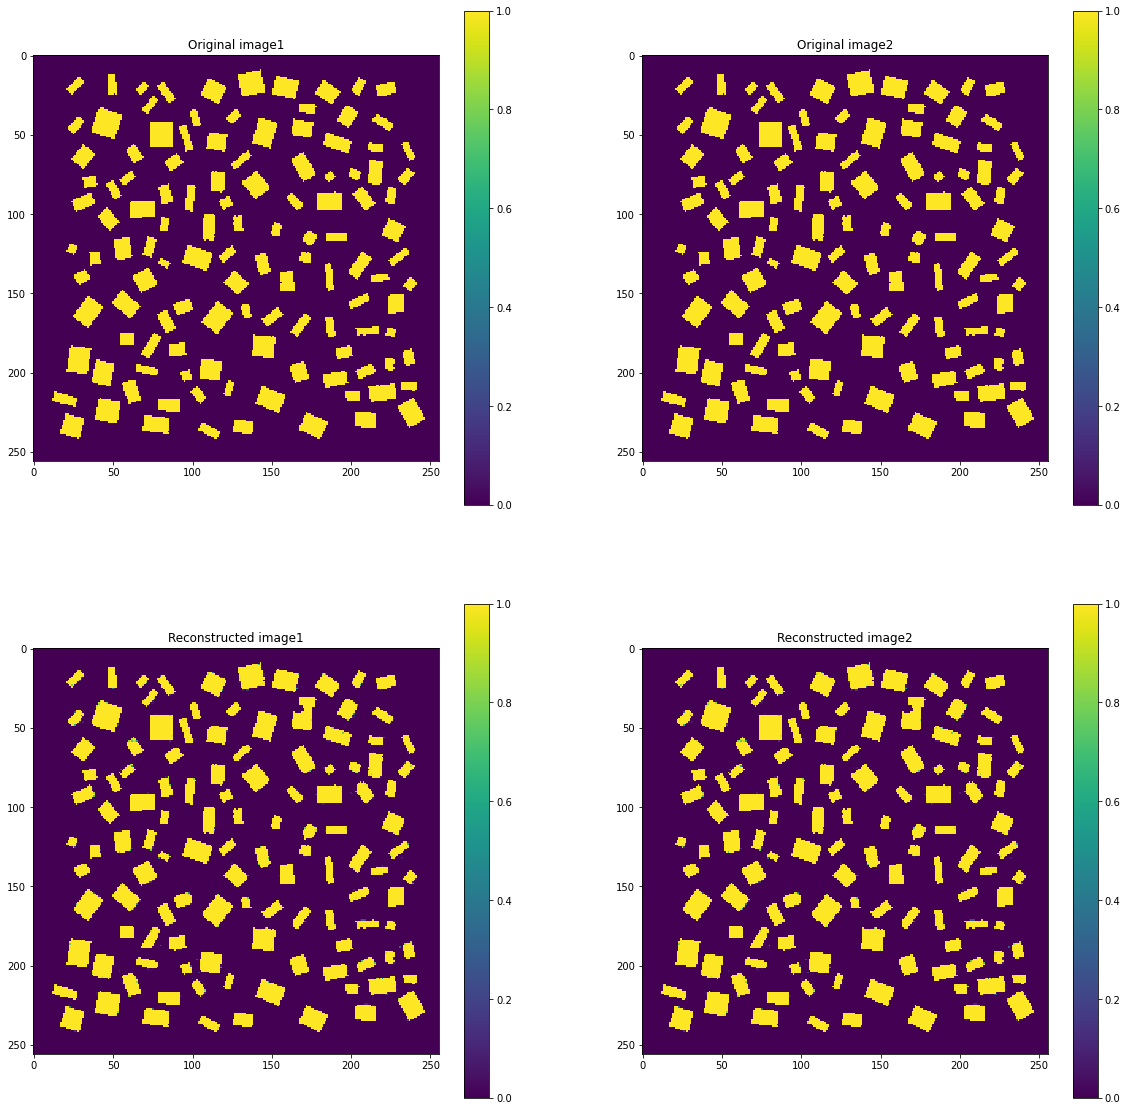

In [15]:
autoencoder.cpu().eval()

dataP = concatenated_data_revalued
print(dataP.shape)

size_start = 0
size_end = 256

plt.figure()

f, axarr = plt.subplots(2,2, figsize=(20, 20))

sub1 = axarr[0][0].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][0].title.set_text('Original image1')
f.colorbar(sub1, ax=axarr[0][0])

sub2 = axarr[0][1].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][1].title.set_text('Original image2')
f.colorbar(sub2, ax=axarr[0][1])

data_rotated = np.rot90(dataP[:, size_start:size_end,size_start:size_end], 4).copy()

input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
latent_space_output = autoencoder.encoder(input_data.view(1, 1, 256, 256))
print('latent space shape', latent_space_output.shape)
res = autoencoder(input_data.view(1, 1, 256, 256))
output_data = res.detach().numpy()
print(output_data.shape)

sub3 = axarr[1][0].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][0].title.set_text('Reconstructed image1')
f.colorbar(sub3, ax=axarr[1][0])

sub4 = axarr[1][1].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][1].title.set_text('Reconstructed image2')
f.colorbar(sub4, ax=axarr[1][1])

plt.show()

(1, 256, 256)
latent space shape torch.Size([1, 1, 32, 32])
(1, 1, 256, 256)


<Figure size 432x288 with 0 Axes>

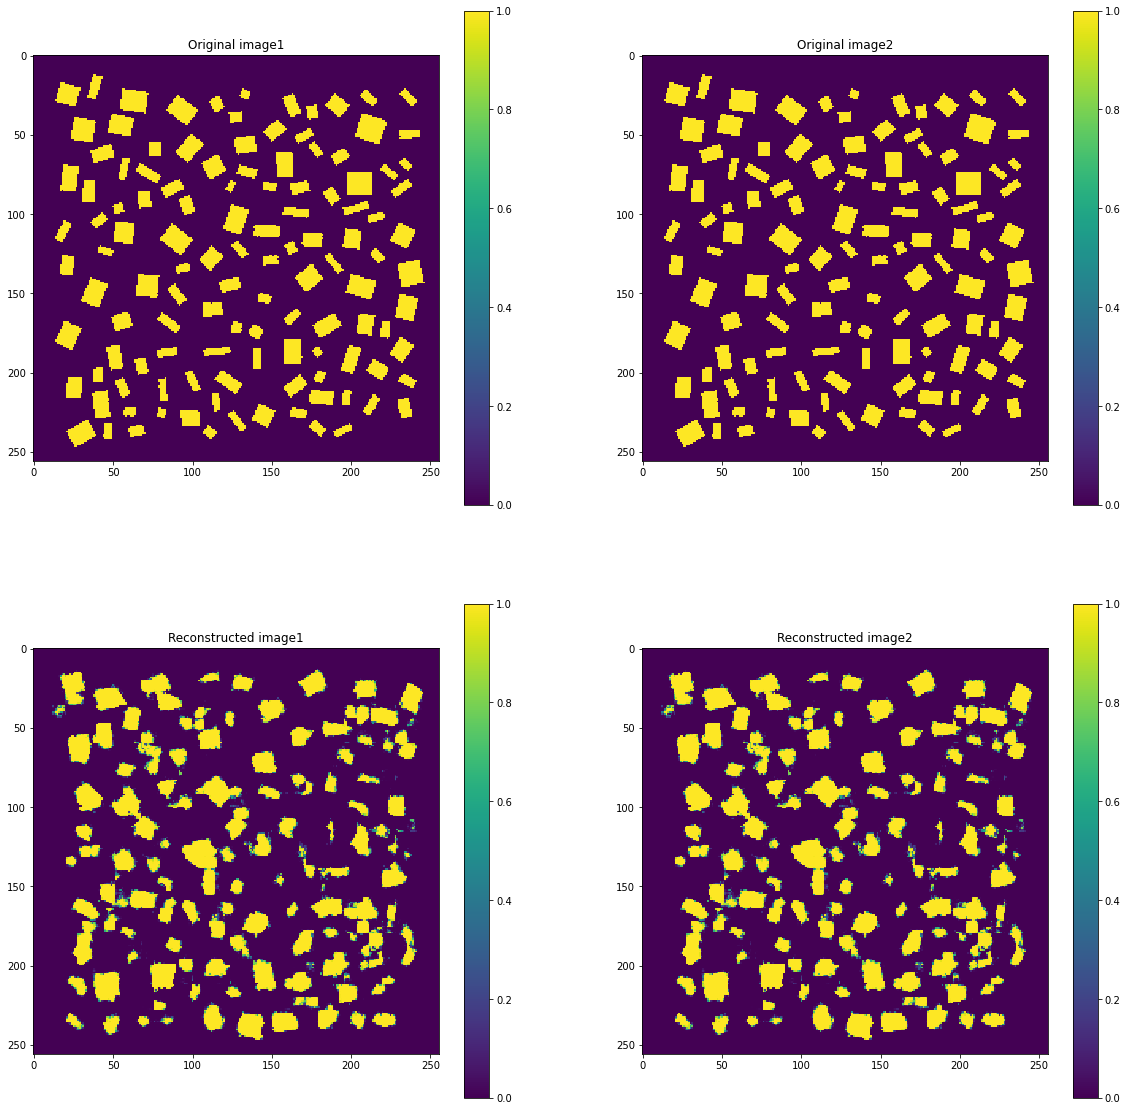

In [188]:
autoencoder.cpu().eval()

dataP = concatenated_data_revalued
print(dataP.shape)

size_start = 0
size_end = 256

plt.figure()

f, axarr = plt.subplots(2,2, figsize=(20, 20))

sub1 = axarr[0][0].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 3), interpolation='none')
axarr[0][0].title.set_text('Original image1')
f.colorbar(sub1, ax=axarr[0][0])

sub2 = axarr[0][1].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 3), interpolation='none')
axarr[0][1].title.set_text('Original image2')
f.colorbar(sub2, ax=axarr[0][1])

data_rotated = np.rot90(dataP[:, size_start:size_end,size_start:size_end], 1).copy()

input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
latent_space_output = autoencoder.encoder(input_data.view(1, 1, 256, 256))
print('latent space shape', latent_space_output.shape)
res = autoencoder(input_data.view(1, 1, 256, 256))
output_data = res.detach().numpy()
print(output_data.shape)

sub3 = axarr[1][0].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][0].title.set_text('Reconstructed image1')
f.colorbar(sub3, ax=axarr[1][0])

sub4 = axarr[1][1].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][1].title.set_text('Reconstructed image2')
f.colorbar(sub4, ax=axarr[1][1])

plt.show()

In [17]:
dataP = concatenated_data_revalued
size_start = 0
size_end = 256

# Extract a region of interest and prepare it for input
data_rotated = dataP[:2, size_start:size_end, size_start:size_end].copy()
print(data_rotated.shape)
input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
print(input_data.shape)

# Pass the input through the encoder to get the latent variable
with torch.no_grad():
    latent_space_output = autoencoder.encoder(input_data)

print('Latent space shape:', latent_space_output.shape)

latent_space_output = latent_space_output.detach().numpy()


print(latent_space_output.shape)

(1, 256, 256)
torch.Size([1, 1, 256, 256])
Latent space shape: torch.Size([1, 1, 32, 32])
(1, 1, 32, 32)


In [18]:
datasetFolder = 'Flow_Data'
xysize = 256

savepath = '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/' + datasetFolder + '/Latent_data_Building_{}_{}_13232.npy'.format(xysize, xysize)

np.save(savepath, latent_space_output)
print('Finished: ' + savepath)

Finished: /home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/Latent_data_Building_256_256_13232.npy


### 9*9 domain

In [189]:
datasetFolder = 'Flow_Data_9_9'
xysize = 384

concatenated_data_384 = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data_9_9/FpB_Interpolated_VelocityAbsorption_384_384.npy')

print(concatenated_data_384.shape)

(2, 384, 384)


In [190]:
concatenated_data_revalued_384 = concatenated_data_384.copy()
concatenated_data_revalued_384[concatenated_data_384 > 1500] = 1
concatenated_data_revalued_384[concatenated_data_384 <= 1500] = 0

concatenated_data_revalued_384 = concatenated_data_revalued_384[0,:,:].reshape(1,xysize,xysize)

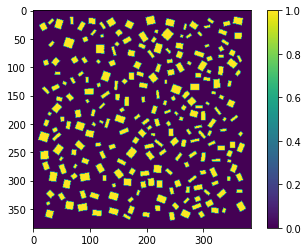

In [191]:
plt.imshow(concatenated_data_revalued_384[0,:,:])
plt.colorbar()

(1, 384, 384)
latent space shape torch.Size([1, 1, 48, 48])
(1, 1, 384, 384)


<Figure size 432x288 with 0 Axes>

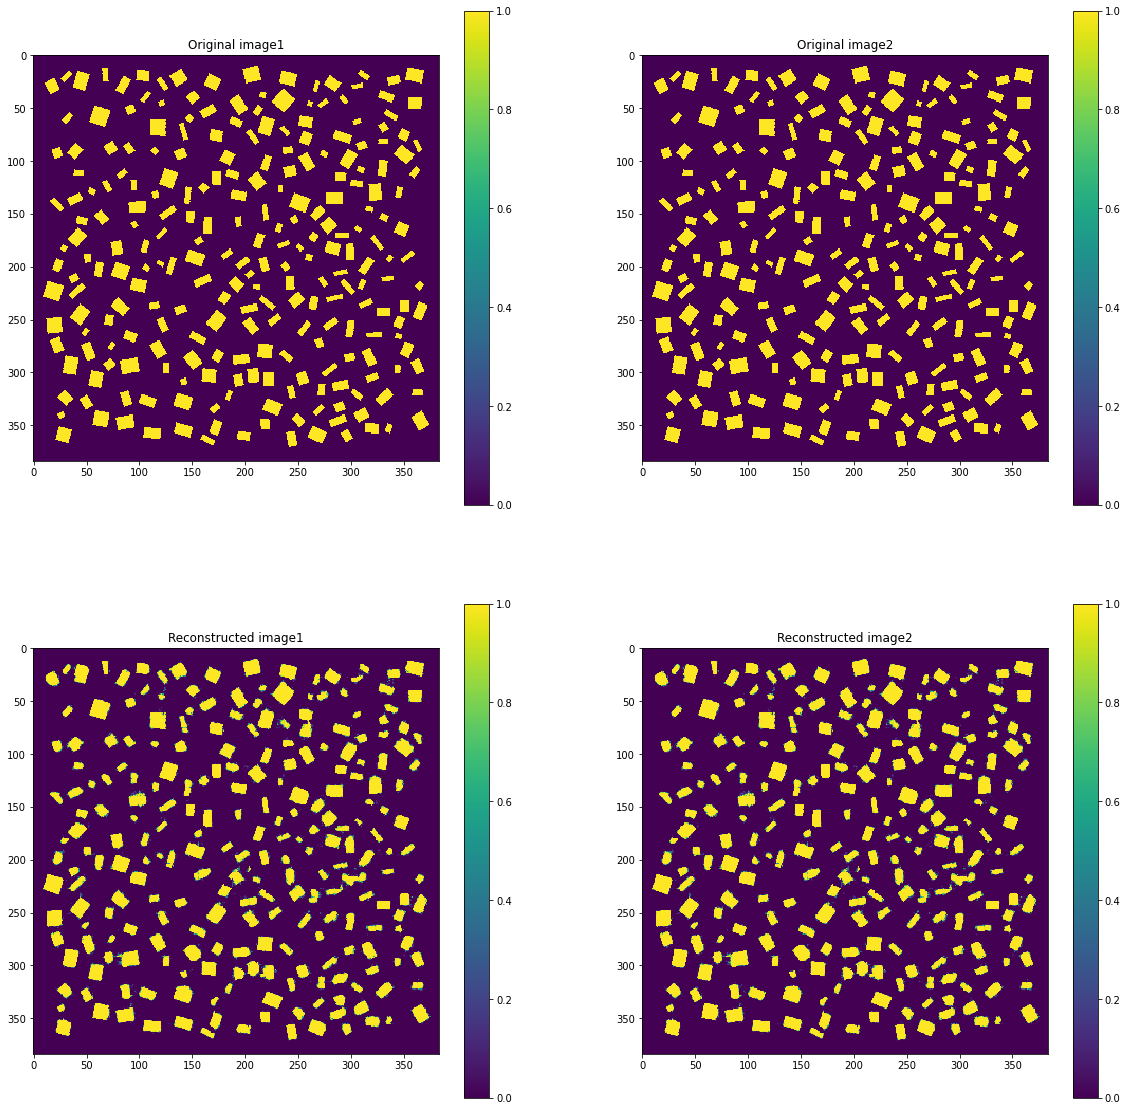

64.0


In [192]:
autoencoder.cpu().eval()

dataP = concatenated_data_revalued_384
print(dataP.shape)

size_start = 0
size_end = xysize

plt.figure()

f, axarr = plt.subplots(2,2, figsize=(20, 20))

sub1 = axarr[0][0].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][0].title.set_text('Original image1')
f.colorbar(sub1, ax=axarr[0][0])

sub2 = axarr[0][1].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][1].title.set_text('Original image2')
f.colorbar(sub2, ax=axarr[0][1])

data_rotated = np.rot90(dataP[:, size_start:size_end,size_start:size_end], 4).copy()

input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
latent_space_output = autoencoder.encoder(input_data.view(1, 1, xysize, xysize))
print('latent space shape', latent_space_output.shape)
res = autoencoder(input_data.view(1, 1, xysize, xysize))
output_data = res.detach().numpy()
print(output_data.shape)

sub3 = axarr[1][0].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][0].title.set_text('Reconstructed image1')
f.colorbar(sub3, ax=axarr[1][0])

sub4 = axarr[1][1].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][1].title.set_text('Reconstructed image2')
f.colorbar(sub4, ax=axarr[1][1])

plt.show()

print((dataP.shape[-1]*dataP.shape[-1])/(latent_space_output.shape[-1]*latent_space_output.shape[-2]*latent_space_output.shape[-3]))

In [62]:
dataP = concatenated_data_revalued_384
size_start = 0
size_end = xysize

# Extract a region of interest and prepare it for input
data_rotated = dataP[:2, size_start:size_end, size_start:size_end].copy()
print(data_rotated.shape)
input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
print(input_data.shape)

# Pass the input through the encoder to get the latent variable
with torch.no_grad():
    latent_space_output = autoencoder.encoder(input_data)

print('Latent space shape:', latent_space_output.shape)

latent_space_output = latent_space_output.detach().numpy()


print(latent_space_output.shape)

(1, 384, 384)
torch.Size([1, 1, 384, 384])
Latent space shape: torch.Size([1, 1, 48, 48])
(1, 1, 48, 48)


In [83]:
384*384/(2*96*96)

8.0

In [82]:
datasetFolder = 'Flow_Data_9_9'
xysize = 384

savepath = '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/' + datasetFolder + '/Latent_data_Building_{}_{}_29696.npy'.format(xysize, xysize)

np.save(savepath, latent_space_output)
print('Finished: ' + savepath)

Finished: /home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data_9_9/Latent_data_Building_384_384_29696.npy
